In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Fri Feb  5 15:40:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install cython pyyaml==5.1

# install detectron2:
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
!python -m detectron2.utils.collect_env

----------------------  ---------------------------------------------------------------
sys.platform            linux
Python                  3.6.9 (default, Oct  8 2020, 12:12:24) [GCC 8.4.0]
numpy                   1.19.5
detectron2              0.3 @/usr/local/lib/python3.6/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0+cu101 @/usr/local/lib/python3.6/dist-packages/torch
PyTorch debug build     True
GPU available           True
GPU 0                   Tesla T4 (arch=7.5)
CUDA_HOME               /usr/local/cuda
Pillow                  8.1.0
torchvision             0.8.1+cu101 @/usr/local/lib/python3.6/dist-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.3.post20210204
cv2                     4.1.2
----------------------  ----------------------------------------------------

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
!rm -r frames/*
!mkdir frames/
#specify path to video
from google.colab import drive
drive.mount('/content/gdrive')
video = '/content/gdrive/My Drive/biomed_j/final 1.mp4' # video

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

mkdir: cannot create directory ‘frames/’: File exists
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

30.0


In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo.
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
#read a random image from the frames folder
import random as r
random_number = r.randint(0,749)
print(random_number)
img = cv2.imread(f"frames/{random_number}.png")

#pass to the model
outputs = predictor(img)

106


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


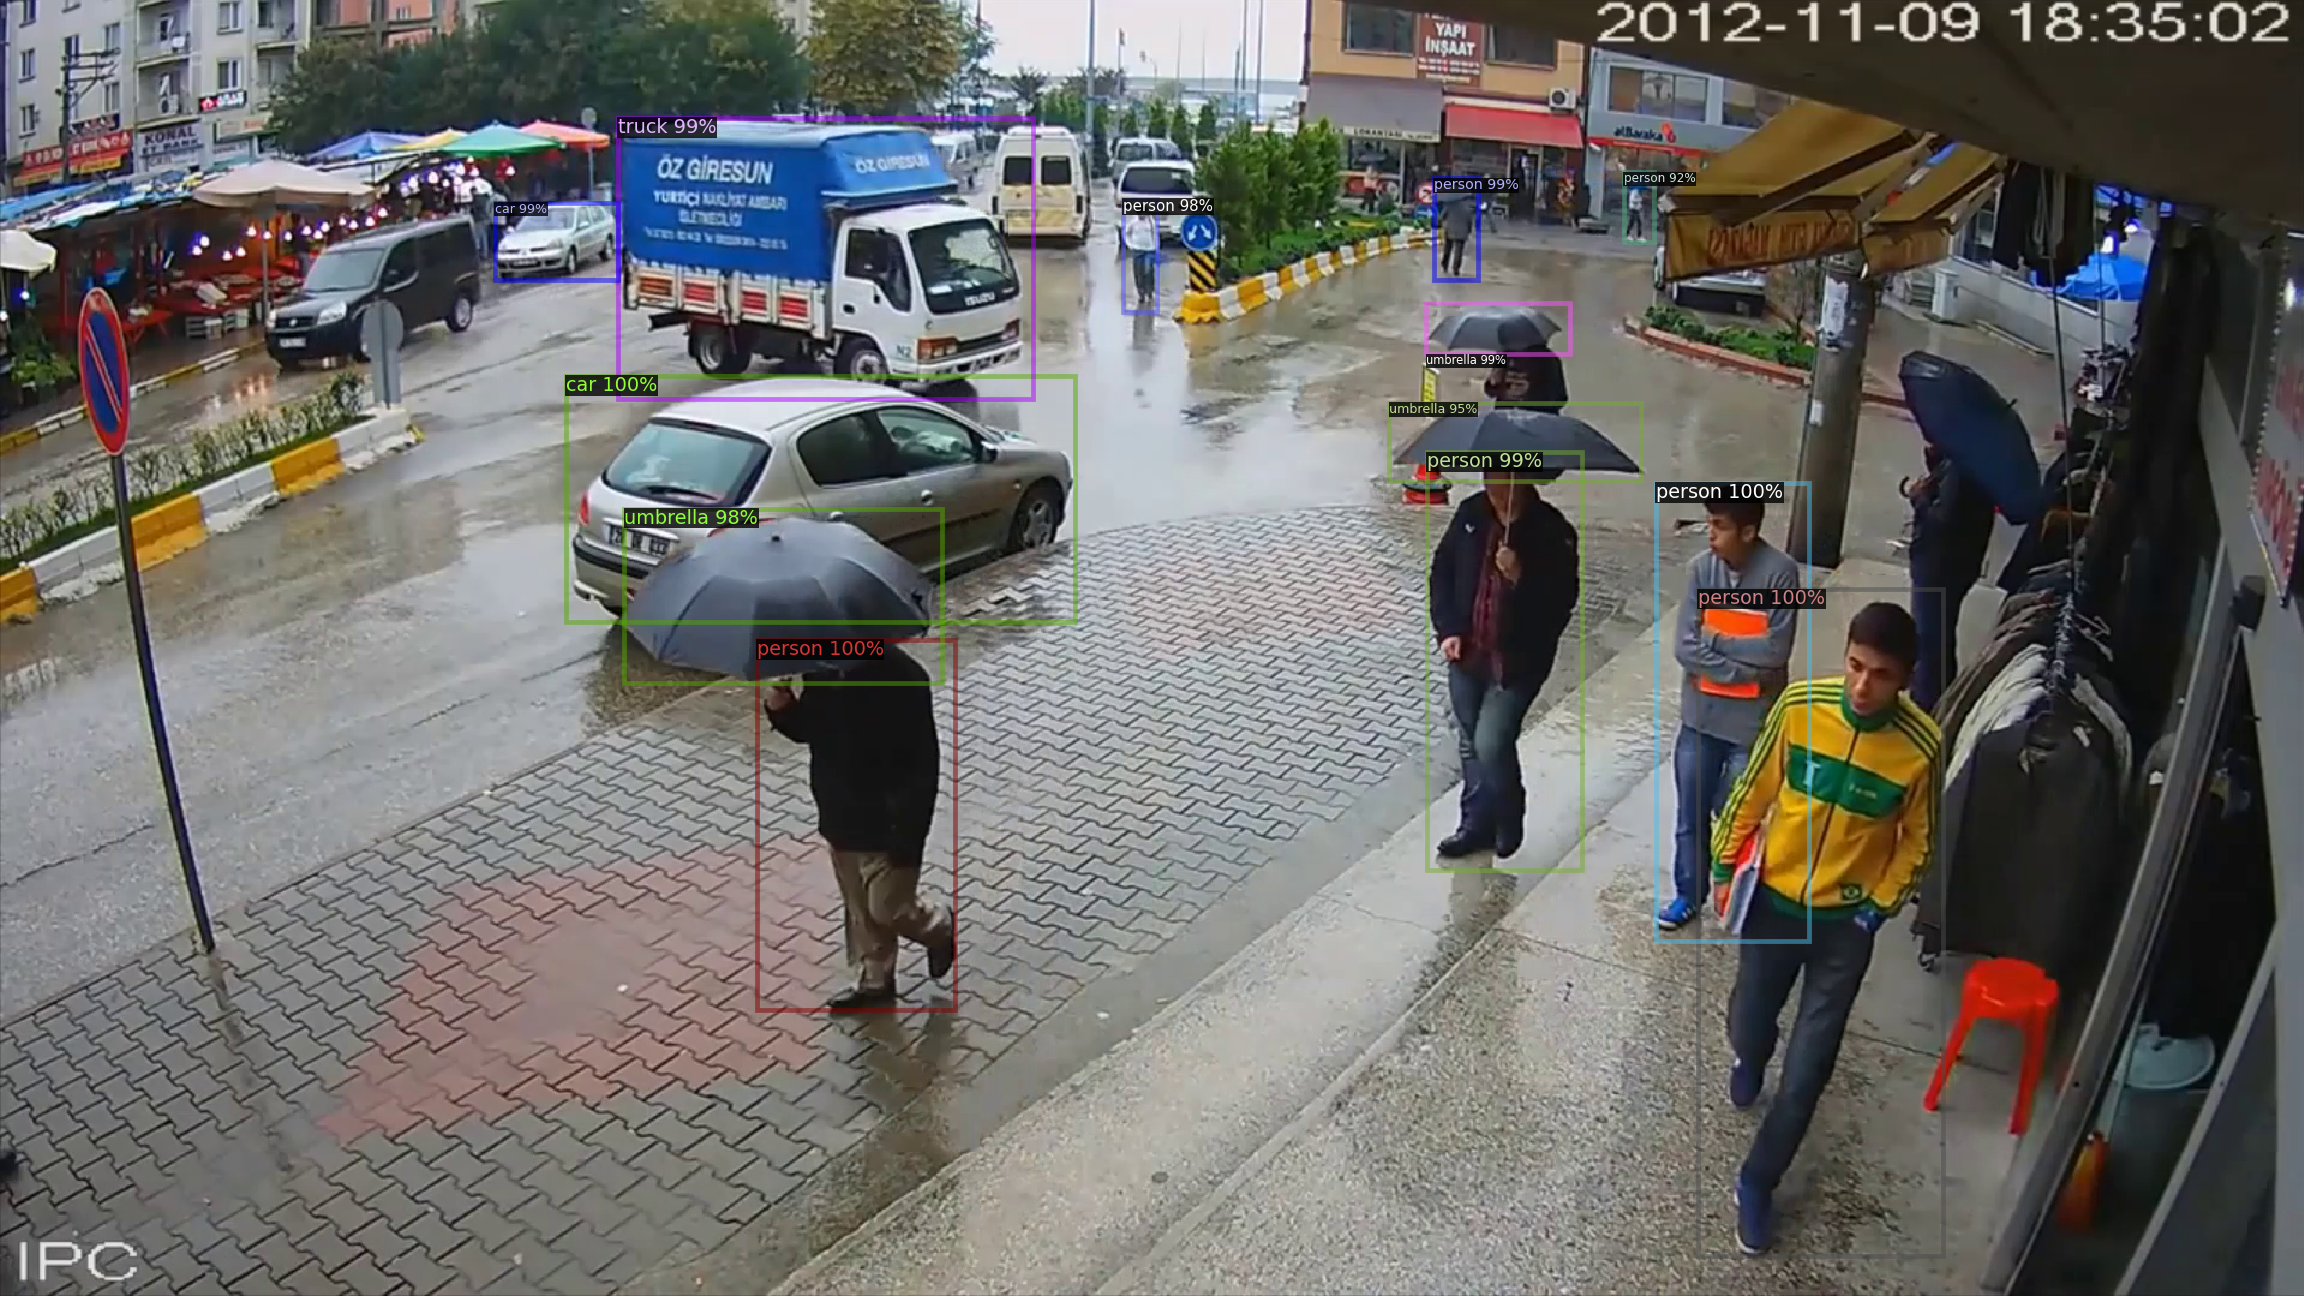

In [ ]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# 0-person ;  1 - potted plant ; 58 - bicycle
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 2  0  0  0  2  7  0  0 25 25  0 25  0]


In [ ]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[ 471.45154  313.21426  895.4672   518.608  ]
 [1379.8003   402.6281  1507.1842   784.0882 ]
 [ 630.46405  533.1508   795.47144  841.70447]
 [1414.702    491.10437 1619.2275  1046.6965 ]
 [ 412.43063  168.9436   514.95685  233.42453]
 [ 514.7714    98.13494  860.5969   332.6778 ]
 [1188.944    377.03436 1318.1405   725.2498 ]
 [1194.9956   148.70541 1231.6143   232.95572]
 [1188.5563   252.90166 1308.1963   295.21887]
 [ 520.2877   423.759    784.6011   568.80945]
 [ 935.8117   165.64578  964.4048   259.7299 ]
 [1157.795    335.9488  1367.7352   400.7647 ]
 [1353.1042   143.61382 1377.9679   201.68025]]


In [ ]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

In [ ]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

1379.8003 402.6281 1507.1842 784.0882


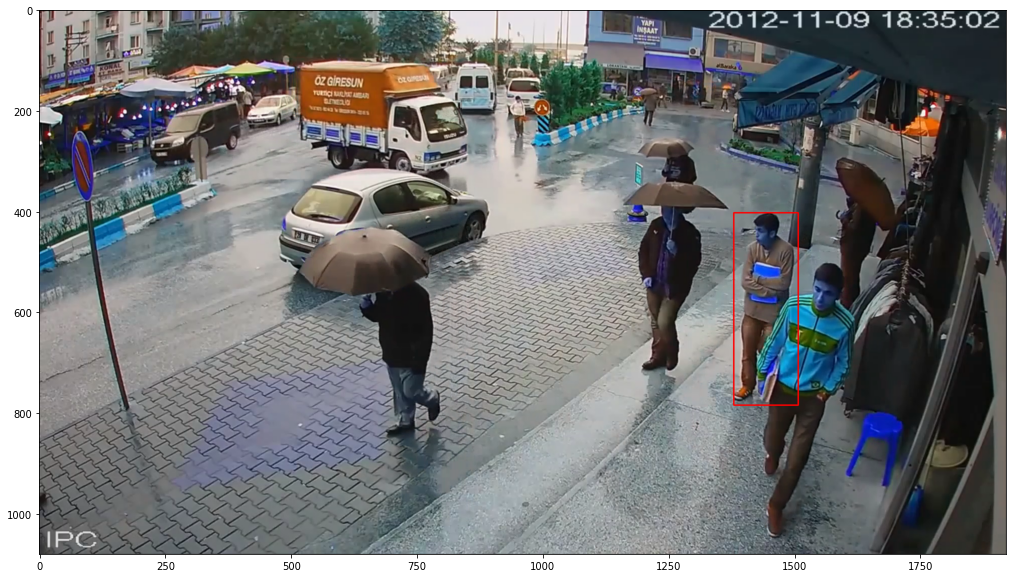

In [ ]:
img = cv2.imread(f'frames/{random_number}.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:
#define a function which return the bottom center of every bbox
def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

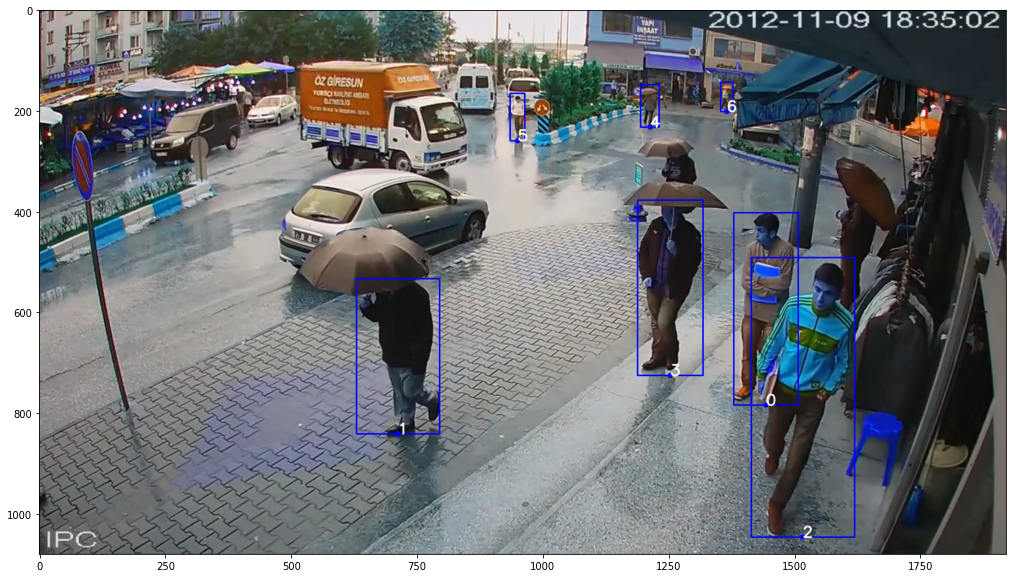

In [ ]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

In [ ]:
dist= compute_distance(midpoints,num)

In [ ]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 15 µs


In [ ]:
import pandas as pd

thresh=200
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2        dist
0   0   3  198.949742
1   4   6  155.128979

In [ ]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

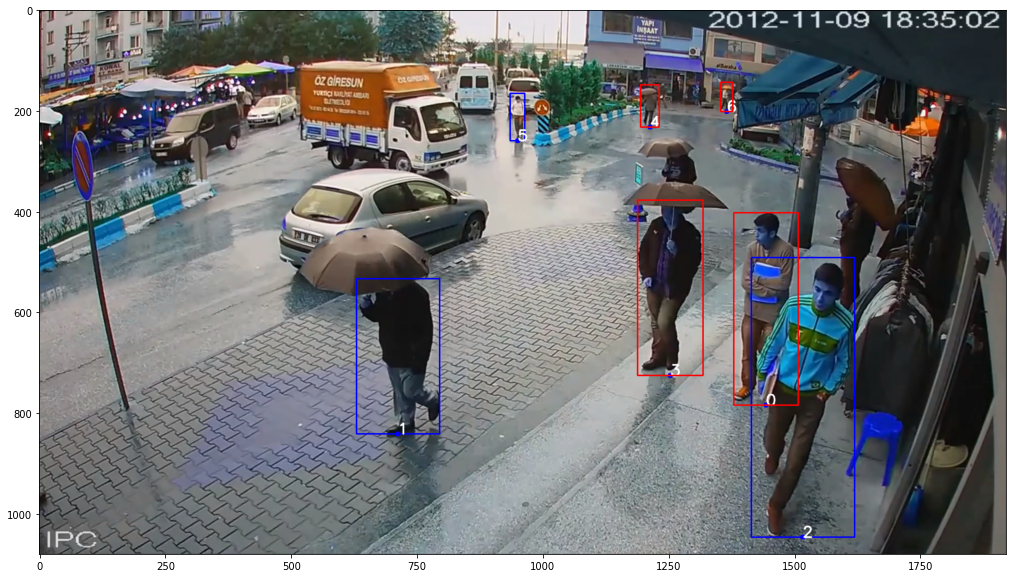

In [ ]:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames/'+name,img)
  return 0

In [ ]:
from tqdm import tqdm
thresh=200
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

100%|██████████| 750/750 [07:16<00:00,  1.72it/s]


In [ ]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('/content/gdrive/My Drive/biomed_j/final1_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 45.2 s, sys: 4.1 s, total: 49.3 s
Wall time: 48.4 s
